# Classical control and feed-forward for photonic channels

In this notebook, we include some examples of implementing quantum (qubit) gates in dual rail encoding, measurement with outcomes and postselection as well as implementations of fusion measurements and fusion-based teleportation protocol with classical corrections. 

In [2]:
from optyx import zx
from optyx.channel import Channel, qmode, qubit, Discard, Measure
from optyx.optyx import Box, tensor, Dim, Mode, Bit, EmbeddingTensor, Id, Swap, DualRail
from optyx.lo import Phase
import numpy as np

## Utility functions and classes

Define a helper function to convert a linear optical unitary into ZW calculus

In [3]:
def unitary_to_zw(U):
    from optyx import zw

    n = U.shape[0]
    diagram = zw.Id(0)

    # construct the initial W layer based on column nonzero counts
    for i in range(n):
        n_i = int(np.abs(np.sign(U)).sum(axis=1)[i])
        if n_i > 1:
            diagram @= zw.W(n_i)
        elif n_i == 1:
            diagram @= zw.Id(1)

    # construct the endomorphism layer
    endo_layer = zw.Id(0)
    for i_1 in range(n):
        for i_2 in range(n):
            if U[i_1, i_2] != 0:
                endo_layer @= zw.Endo(U[i_1, i_2])

    diagram >>= endo_layer

    # get the swap list based on input and output connections
    swap_list = []
    for i_1 in range(n):
        for i_2 in range(n):
            if U[i_2, i_1] != 0:
                swap_list.append(n * i_2 + i_1)

    # remove -1s (no connections) and adjust indices for missing elements
    n_s_output = list(np.abs(np.sign(U)).flatten())
    adjusted_swap_list = []
    for idx in swap_list:
        sum_missing = np.abs(np.array(n_s_output)[:idx] - 1).sum()
        adjusted_swap_list.append(int(idx - sum_missing))

    # permute
    diagram = diagram.permute(*adjusted_swap_list)

    # the W-dagger layer based on row nonzero counts
    w_dagger_layer = zw.Id(0)
    for i in range(n):
        n_i = int(np.abs(np.sign(U)).sum(axis=0)[i])
        if n_i > 1:
            w_dagger_layer @= zw.W(n_i).dagger()
        elif n_i == 1:
            w_dagger_layer @= zw.Id(1)

    diagram >>= w_dagger_layer

    return diagram

The definition of beam splitter in Optyx is somewhat inconvenient for the examples in the notebook; here, we pick a definition which implements a Hadamard gate in the dual rail encoding

In [4]:
BS_matrix = np.sqrt(1/2) * np.array([[1, 1], [1, -1]])

BS = Box("BS", Mode(2), Mode(2))

BS.to_zw = lambda: unitary_to_zw(BS_matrix)

BS.conjugate = lambda: BS

To facilitate classical control, we need to have a method of measurement -- obtaining classical information from the photonic channel. Here, we choose a gadget which maps all photon counts over 1 into bit 1 while zero photons is mapped to bit 0. Therefore, it detects if any photons are present at the measurement device.

This is also called a non-photon resolving detector or a photon threshold detector.

In [5]:
class PhotonThresholdDetector(Box):
    """
    Non-photon resolving detector from a mode to a bit.
    Detects whether one or more photons are present.
    """

    def __init__(self):
        super().__init__("PTD", Mode(1), Bit(1))

    def to_zw(self):
        return self

    def truncation(self, input_dims = None, output_dims = None):
        array = np.zeros((input_dims[0], 2), dtype=complex)
        array[0, 0] = 1
        array[1:input_dims[0], 1] = 1
        return tensor.Box(self.name, Dim(int(input_dims[0])), Dim(2), array)

    def determine_output_dimensions(self, input_dims):
        return [2]*len(input_dims)

    def conjugate(self):
        return self

The classes below implement controlled gates needed in this notebook. All of them apply a photonic gate if the classical bit is 1.

In [6]:
class ControlledPhase(Box):
    """
    A controlled phase box, where a phase is applied
    if the classical controlled bit is 1.
    """

    def __init__(self, angle=0):
        super().__init__("ControlledPhase", Bit(1) @ Mode(1), Mode(1))
        self.angle = angle

    def to_zw(self):
        return self

    def determine_output_dimensions(self, input_dims):
        return [input_dims[1]]

    def truncation(self, input_dims = None, output_dims = None):
        array = np.zeros((input_dims[0],
                          input_dims[1],
                          output_dims[0]), dtype=complex)
        array_id = np.eye(input_dims[1], output_dims[0])

        exp = np.exp(2 * np.pi * 1j * self.angle)
        diag_size = max(input_dims[1], output_dims[0])
        array_phase = np.diag([exp ** i for i in range(diag_size)])
        array_phase = array_phase[:input_dims[1], :output_dims[0]]

        array[0, :, :] = array_id
        array[1, :, :] = array_phase

        return tensor.Box(self.name, Dim(*input_dims), Dim(*output_dims), array)

    def conjugate(self):
        return ControlledPhase(-self.angle)


class ControlledBS(Box):
    """
    A controlled beam splitter box, where a beam splitter is applied
    if the classical controlled bit is 1.
    """

    def __init__(self):
        super().__init__("ControlledBS", Bit(1) @ Mode(2), Mode(2))

    def to_zw(self):
        return self

    def determine_output_dimensions(self, input_dims):
        bs = BS.to_zw().to_tensor(input_dims=input_dims[1:]).eval()
        output_dims = bs.cod.inside
        return list(output_dims)

    def truncation(self, input_dims = None, output_dims = None):
        bs = BS.to_zw().to_tensor(input_dims=input_dims[1:]).eval()
        array_bs = bs.array
        output_dims = bs.cod.inside
        array = np.zeros((*input_dims, *output_dims), dtype=complex)
        embedding = tensor.Id(Dim(1))
        for i in range(len(input_dims[1:])):
            embedding @= EmbeddingTensor(input_dims[i+1], output_dims[i])
        array_id = (Id(Mode(len(input_dims[1:]))).to_zw().to_tensor(input_dims=input_dims[1:]) >>
                    embedding).eval().array

        array[0, :, :] = array_id
        array[1, :, :] = array_bs

        return tensor.Box(self.name, Dim(*input_dims), Dim(*output_dims), array)

    def conjugate(self):
        return self

## Examples

### Qubit gates in dual rail encoding

Below, we check the correctness of the implementations of qubit gates in the dual rail encoding

In [7]:
from discopy.drawing import Equation

In [8]:
hadamard_dual_rail = (
    DualRail() >>
    BS >>
    DualRail().dagger()
)

hadamard = zx.H

hadamard_dual_rail_tensor = hadamard_dual_rail.to_zw().to_tensor().eval().array.flatten()

hadamard_tensor = hadamard.to_tensor().eval().array.flatten()

np.allclose(hadamard_dual_rail_tensor, hadamard_tensor)

True

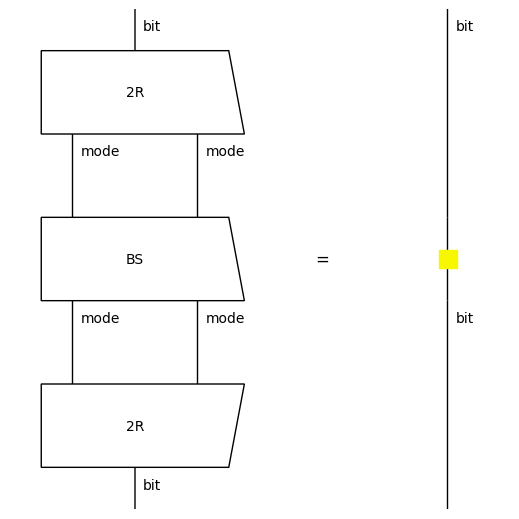

In [9]:
Equation(hadamard_dual_rail, hadamard).draw(figsize=(5, 5))

In [10]:
phase_dual_rail = (
    DualRail() >>
    Mode(1) @ Phase(0.5) >>
    DualRail().dagger()
)

phase = zx.Z(1, 1, 0.5)

phase_dual_rail_tensor = phase_dual_rail.to_zw().to_tensor().eval().array.flatten()

phase_tensor = phase.to_tensor().eval().array.flatten()

np.allclose(phase_dual_rail_tensor, phase_tensor)

True

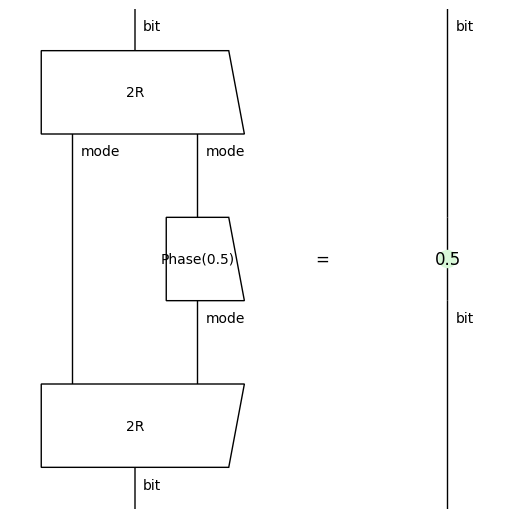

In [11]:
Equation(phase_dual_rail, phase).draw(figsize=(5, 5))

### Measurement

We cannot implement postselection physically as measurement is probabilistic in quantum mechanics. In the examples below, we show how to use classical outcomes to postselect on outcomes we want to obtain.

In [12]:
# some utility definitions

postselect_1 = zx.X(1, 0, 0.5)
postselect_0 = zx.X(1, 0)
xor = zx.X(2, 1)
copy =  zx.Z(1, 2)
swap = Swap(Bit(1), Bit(1))

Let's try the Z measurement first:

In [13]:
phase = 0.3

# Z measurement - we postselect on the 1 outcome, by discarding the outcome of the measurement of the first mode and postselecting
# the outcome of the measurement of the second mode

# dual rail encoding >> phase shift >> beam splitter >> photon threshold detectors
measurement_Z_kraus_map = (
    DualRail() >>
    Mode(1) @ Phase(phase) >>
    BS >>
    PhotonThresholdDetector() @ PhotonThresholdDetector()
)

measurement_Z_channel = Channel("Z measurement", measurement_Z_kraus_map) >> Discard(qubit) @ Measure(qubit)

#postselect the on the outcome 1 in the second mode
measurement_Z_postselected = measurement_Z_channel.double() >> postselect_1

density_mode = measurement_Z_postselected.to_zw().to_tensor().eval().array


In [14]:
#check the result

#this is the map which should be implemented by the channel above
measurement_Z_qubit_kraus_map = (
    zx.Z(1, 0, phase + 0.5)
)

measurement_Z_qubit_channel = Channel("Z measurement", measurement_Z_qubit_kraus_map)

density_qubit = measurement_Z_qubit_channel.double().to_zw().to_tensor().eval().array

In [15]:
#normalise since we do omit the scalars in our analysis so magnitudes might differ
np.allclose(density_mode/density_mode.sum(), density_qubit/density_qubit.sum())

True

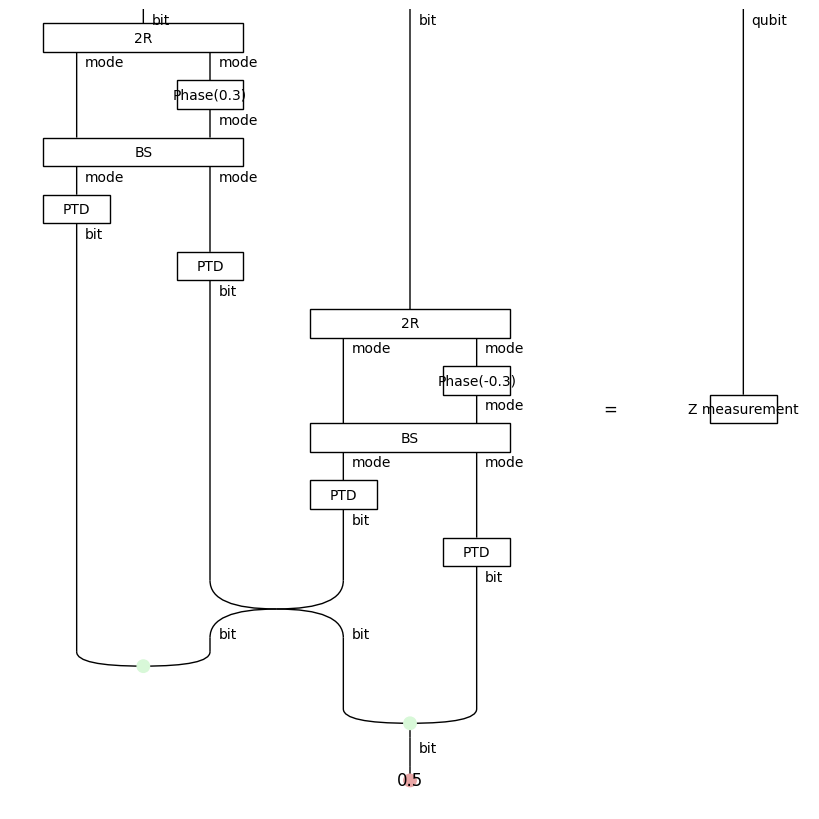

In [ ]:
Equation(measurement_Z_postselected, measurement_Z_qubit_channel.double()).draw(figsize=(8, 8))

X measurement - a Hadamard gate (the beam splitter) with a Z measurement:

In [17]:
phase = 0.65

measurement_X_kraus_map = (
    DualRail() >>
    BS >>
    Mode(1) @ Phase(phase) >>
    BS >>
    PhotonThresholdDetector() @ PhotonThresholdDetector()
)

measurement_X_channel = Channel("Z measurement", measurement_X_kraus_map) >> Discard(qubit) @ Measure(qubit)

measurement_X_postselected = measurement_X_channel.double() >> postselect_1

density_mode = measurement_X_postselected.to_zw().to_tensor().eval().array

In [18]:
measurement_X_qubit_kraus_map = (
    zx.X(1, 0, phase + 0.5)
)

measurement_X_qubit_channel = Channel("Z measurement qubit", measurement_X_qubit_kraus_map)

density_qubit = measurement_X_qubit_channel.double().to_zw().to_tensor().eval().array

In [19]:
np.allclose(density_mode/density_mode.sum(), density_qubit/density_qubit.sum())

True

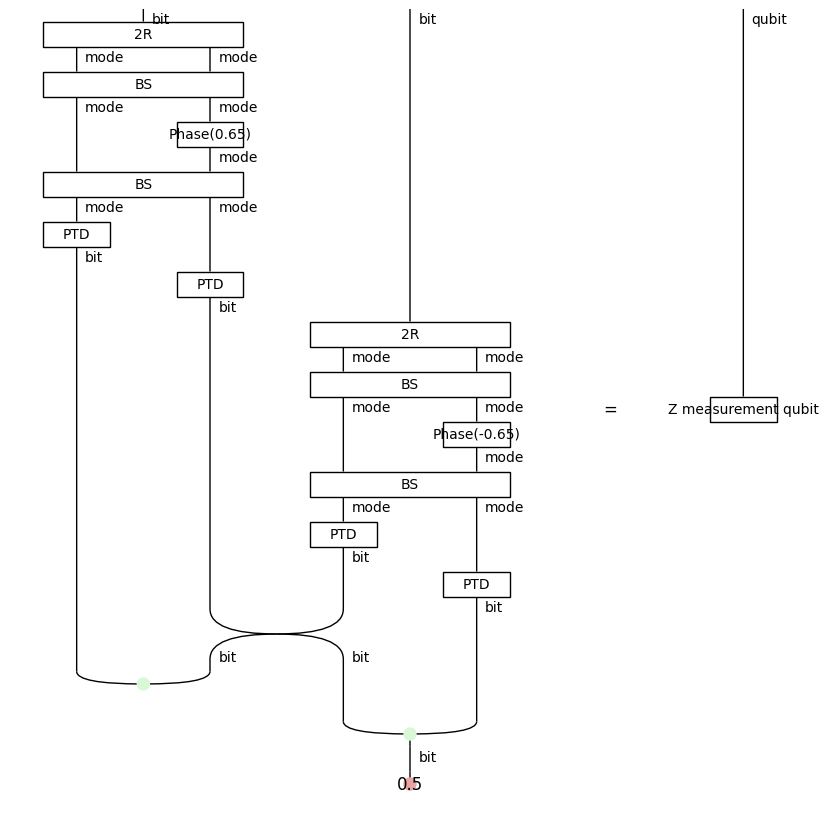

In [20]:
Equation(measurement_X_postselected, measurement_X_qubit_channel).draw(figsize=(8, 8))

### Fusion measurements

The aim of fusion measurements is to achieve an entangling operatation. The measurements are probabilistic though. They can fail to produce entanglement and even in the case of success they can introduce unwanted Pauli byproducts. 

We can use the classical outcomes of measurements to either postselect on the outcomes we want or to correct the byproducts

#### Type I fusion - postselection on the success case and no errors/byproducts

This is the most simple example. We measure both mode pairs and then use the resulting two bits to postselect on the case when the measurement is the Bell measurement without byproducts.

In [21]:
# define the Kraus map for the type I fusion measurement
kraus_fusion_1 = (
    DualRail() @ DualRail() >>
    Mode(1) @ Swap(Mode(1), Mode(1)) @ Mode(1) >>
    Mode(1) @ BS @ Mode(1) >>
    Mode(1) @ PhotonThresholdDetector() @ PhotonThresholdDetector() @ Mode(1) >>
    Swap(Mode(1), Bit(1)) @ Bit(1) @ Mode(1) >>
    Bit(1) @ Swap(Mode(1), Bit(1)) @ Mode(1)
)

fusion_1_channel = Channel("Type I Fusion", kraus=kraus_fusion_1) >> Measure(qubit) @ Measure(qubit) @ qmode**2

# here we postselect on the success outcome of the fusion measurement and on no byproducts so no corrections are needed
# bit a is 1 and bit b is 0
fusion_1_channel_postselected_success_no_error = (
    fusion_1_channel.double() >>
    (postselect_1 @ postselect_0) @ Mode(4) >>
    Mode(1) @ Swap(Mode(1), Mode(1)) @ Mode(1) >>
    DualRail().dagger() @ DualRail().dagger()
)

density_fusion_1_postselected_no_error = fusion_1_channel_postselected_success_no_error.to_zw().to_tensor().eval().array

In [22]:
# The operation above should product the following map:

kraus_split = (
    zx.Z(2, 1)
)

split_channel = Channel("Split", kraus=kraus_split)

split_channel_double = split_channel.double()

density_split = split_channel_double.to_zw().to_tensor().eval().array

In [23]:
np.allclose(density_fusion_1_postselected_no_error, density_split)

True

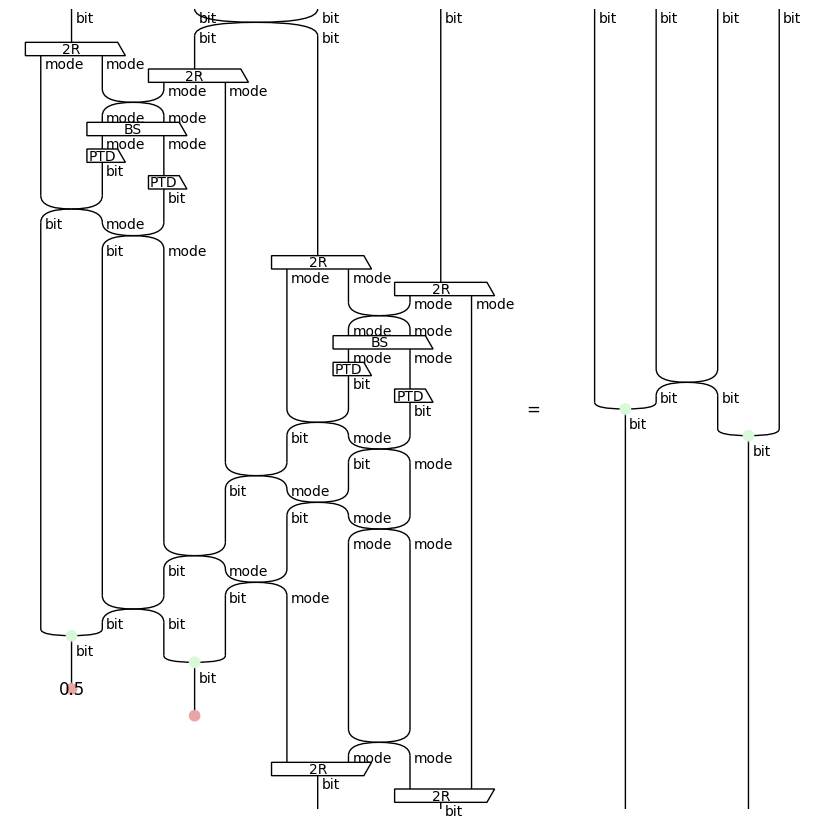

In [24]:
Equation(fusion_1_channel_postselected_success_no_error, split_channel_double).draw(figsize=(8, 8))

#### Type I fusion - postselection on the success case and using a phase shifter to correct the errors

Here we apply a correction on the success case. We measure both mode pairs and then use the resulting two bits figure out whether to apply a correction or not. In this case the classical computation is simply an XOR between the bits.

In [25]:
fusion_1_channel = Channel("Type I Fusion", kraus=kraus_fusion_1) >> Measure(qubit) @ Measure(qubit) @ qmode**2

# apply the XOR here
classical_postselection_error_correction = (
    Bit(1) @ copy >>
    xor @ Bit(1) >>
    postselect_1 @ Bit(1)
)

# define the correction
fusion_1_correction_kraus = (
    ControlledPhase(0.5) @ Mode(1) >>
    DualRail().dagger()
)

fusion_1_correction_channel_doubled = zx.Z(1, 2) @ Mode(4) >> Channel("Type I Fusion Correction", kraus=fusion_1_correction_kraus).double()


fusion_1_channel_postselected_success_error_correction = (
    fusion_1_channel.double() >>
    classical_postselection_error_correction @ Mode(4) >>
    fusion_1_correction_channel_doubled
)

density_fusion_1_postselected_success_error_correction = fusion_1_channel_postselected_success_error_correction.to_zw().to_tensor().eval().array


In [26]:
np.allclose(density_fusion_1_postselected_success_error_correction, density_split)

True

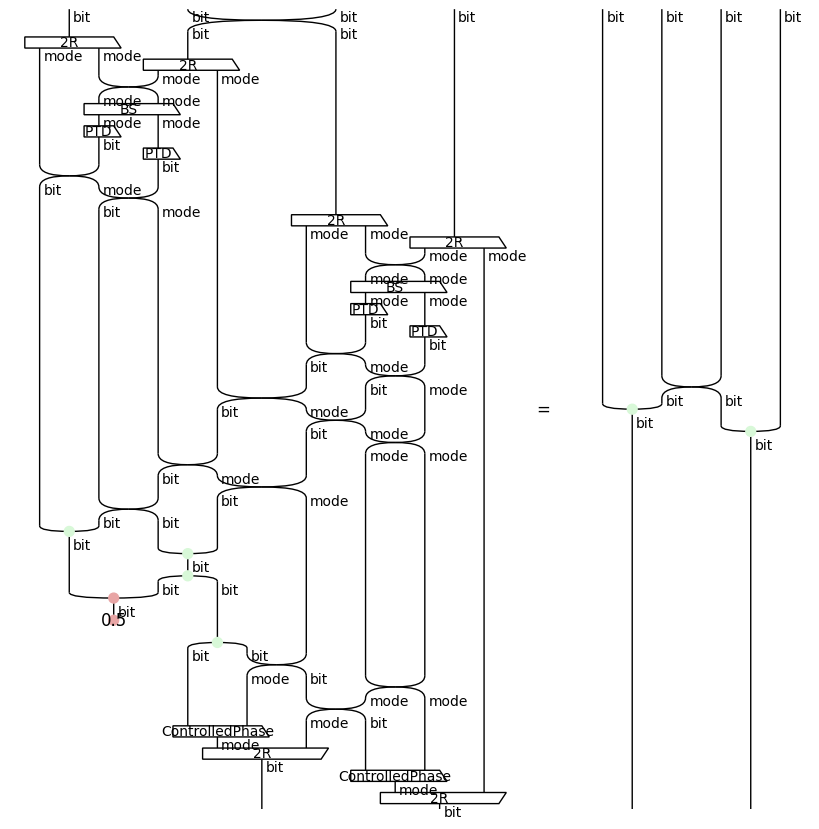

In [27]:
Equation(fusion_1_channel_postselected_success_error_correction, split_channel_double).draw(figsize=(8, 8))

## Teleportation using type II fusion measurement

In this example, we combine all the elements of the example from above to define a teleportation protocol using fusion measurements. We postselect on the success case (so that an entangling measurement in applied) and then correct any unwanted byproducts using a controlled phase shifter,

In [28]:
kraus_fusion_2 = (
    kraus_fusion_1 >>
    Bit(1) @ Bit(1) @ BS >>
    Bit(1) @ Bit(1) @ PhotonThresholdDetector() @ PhotonThresholdDetector()
)

def teleport(input_state: zx.Diagram, return_map = False) -> np.array:
    if return_map:
        input_state = Bit(1)
    kraus_teleport = (
        input_state @ zx.Z(0, 2) >>
        Bit(1) @ Bit(1) @ DualRail() >>
        kraus_fusion_2 @ Id(Mode(2))
    )

    kraus_teleport_channel = (Channel("Teleport", kraus=kraus_teleport) >>
                              Measure(qubit) @ Measure(qubit) @ Measure(qubit) @ Measure(qubit) @ qmode**2)
    kraus_teleport_channel_doubled = kraus_teleport_channel.double()

    kraus_correction = (
        ControlledPhase(0.5) @ Mode(1) >>
        DualRail().dagger()
    )

    # we require a = not b, c = not d, and the correction is d XOR b
    classical_circuit = (
        Bit(2) @ swap >>
        Bit(1) @ copy @ copy @ Bit(1) >>
        xor @ xor @ xor >>
        postselect_1 @ Bit(1) @ postselect_1
    )

    channel_correction = Channel("s", kraus=kraus_correction)
    channel_correction_doubled = ((zx.Z(1, 2) @ Mode(4)) >>
                                  channel_correction.double())

    map = (kraus_teleport_channel_doubled >>
           classical_circuit @ Mode(4) >>
           channel_correction_doubled)

    arr = map.to_zw().to_tensor().eval().array

    if return_map:
        return map
    return arr

In [29]:
states_to_teleport = [
    zx.Z(0, 1),
    zx.X(0, 1),
    zx.X(0, 1, 0.5),
    zx.X(0, 1, 0.3456) >> zx.Z(1, 1, 0.34534),
    zx.X(0, 1, 0.25)
]

In [30]:
for state_to_teleport in states_to_teleport:
    density_teleported = teleport(state_to_teleport)

    density_teleported = density_teleported/density_teleported.sum()

    logical_channel = Channel("Logical", state_to_teleport)

    density_logical = logical_channel.double().to_zw().to_tensor().eval().array

    density_logical = density_logical/density_logical.sum()

    print(np.allclose(density_teleported, density_logical))

True
True
True
True
True


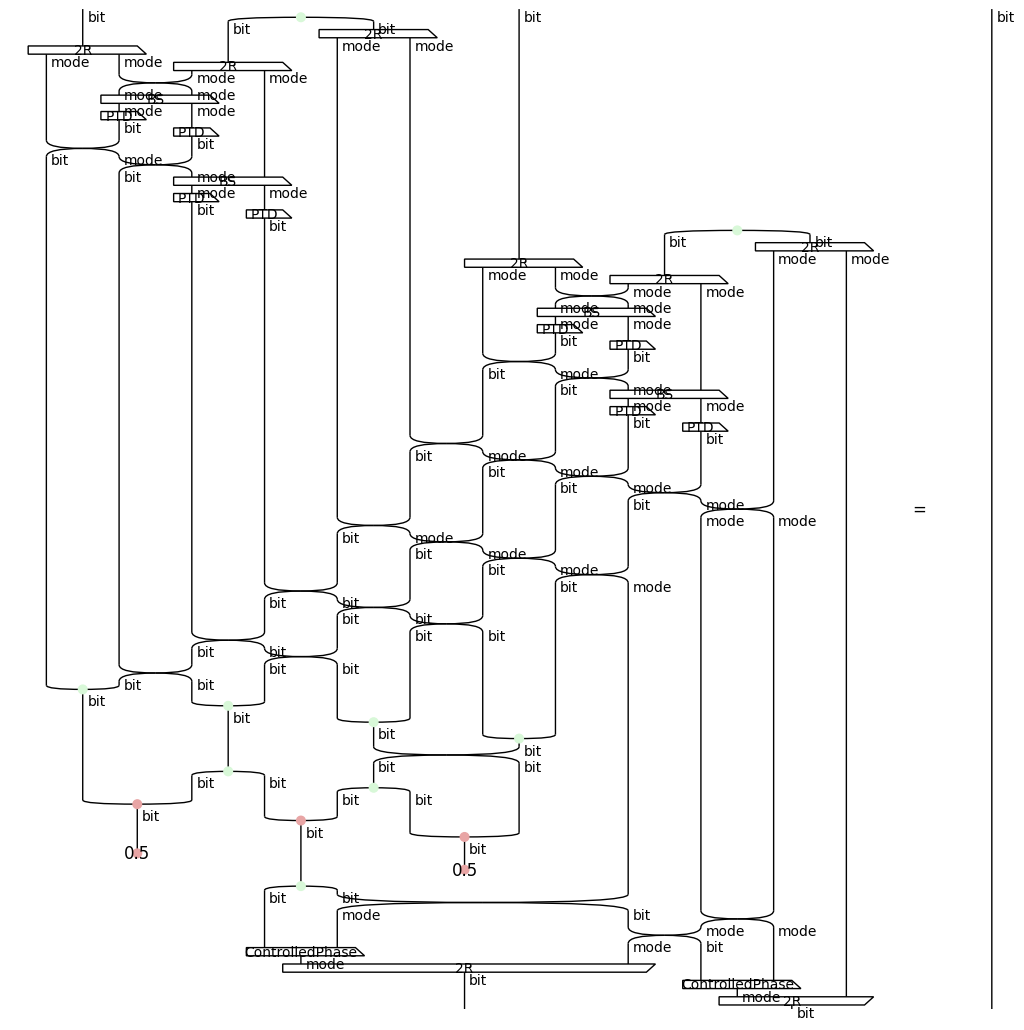

In [ ]:
Equation(teleport(None, return_map=True), Id(Bit(2))).draw(figsize=(10, 10))